In [38]:
from functools import partial
from tqdm import tqdm
import jax
import jax.numpy as jnp
import jax.random as jr
import flax.linen as nn
import optax
from flax.training import train_state
import matplotlib.pyplot as plt

In [39]:
key = jr.key(42)

# Meta-learning with MAML

Let us consider a toy meta learning example taken from the MAML paper: regression of sinusoidal data with randomized amplitude and phases.

In [40]:
# lower and upper bounds for the sinusoidal dataset parameters
xl = -5.0
xu = 5.0
al = 0.1
au = 0.5
pl = 0.0
pu = 2 * jnp.pi

In [41]:
batch_size = 32 # meta batch size for MAML
K = 5 # K-shot regression

Let us define the synthetic dataset distribution

In [42]:
def sample_datasets(key, batch_size, K, noise_std=0.0, return_params=False):

    """
    Sample a batch of tasks from the sine function with random phases and amplitudes.
    Each task is defined by a different amplitude and phase shift.
    """
    key_amp, key_phase, key_x, key_e = jr.split(key, 4)
    
    amplitudes = jr.uniform(key_amp, shape=(batch_size,), minval=al, maxval=au)
    phases = jr.uniform(key_phase, shape=(batch_size,), minval=pl, maxval=pu)
    batch_x = jr.uniform(key_x, shape=(batch_size, K), minval=xl, maxval=xu)
    batch_y = amplitudes[:, None] * jnp.sin(batch_x + phases[:, None])
    batch_y += jr.normal(key_e, shape=batch_y.shape) * noise_std  # Add noise

    batch_x = batch_x[..., None]
    batch_y = batch_y[..., None]
    
    if return_params:
        # Return the parameters used to generate the tasks, useful for performance evaluation and plotting
        return batch_x, batch_y, amplitudes, phases
    else:
        # Return only the inputs and outputs
        return batch_x, batch_y


Let us sample a few "validation datasets", that we will use to evaluate the performance of MAML vs. standard initialization

In [43]:
key, subkey = jr.split(key)
batch_x_val, batch_y_val, amplitudes, phases = sample_datasets(subkey, batch_size=batch_size, K=K, return_params=True)

Let us visualize a few of those datasets, together with the true underlying function (which, in spirit, is assumed unknown)

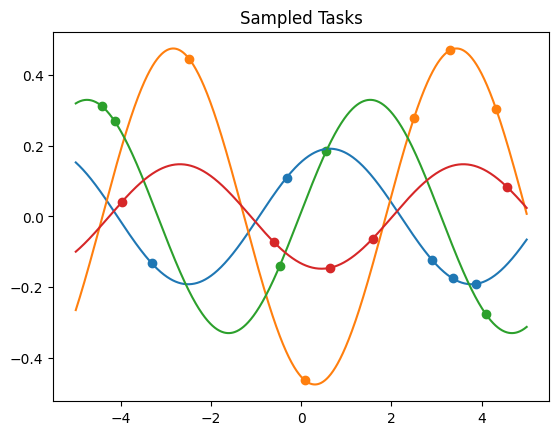

In [44]:
x_dense = jnp.linspace(xl, xu, 1000)
batch_y_val_dense = amplitudes[:, None] * jnp.sin(x_dense + phases[:, None])

plot_num = 4 # datasets to be visualized
plt.figure()
plt.title("Sampled Tasks")
plt.plot(batch_x_val[:plot_num, :, 0].T, batch_y_val[:plot_num, :, 0].T, 'o')
plt.gca().set_prop_cycle(None)  # Reset the color cycle to ensure the same colors are used
plt.plot(x_dense, batch_y_val_dense[:plot_num].T);

It might be more effective to visualize tasks in different subplots

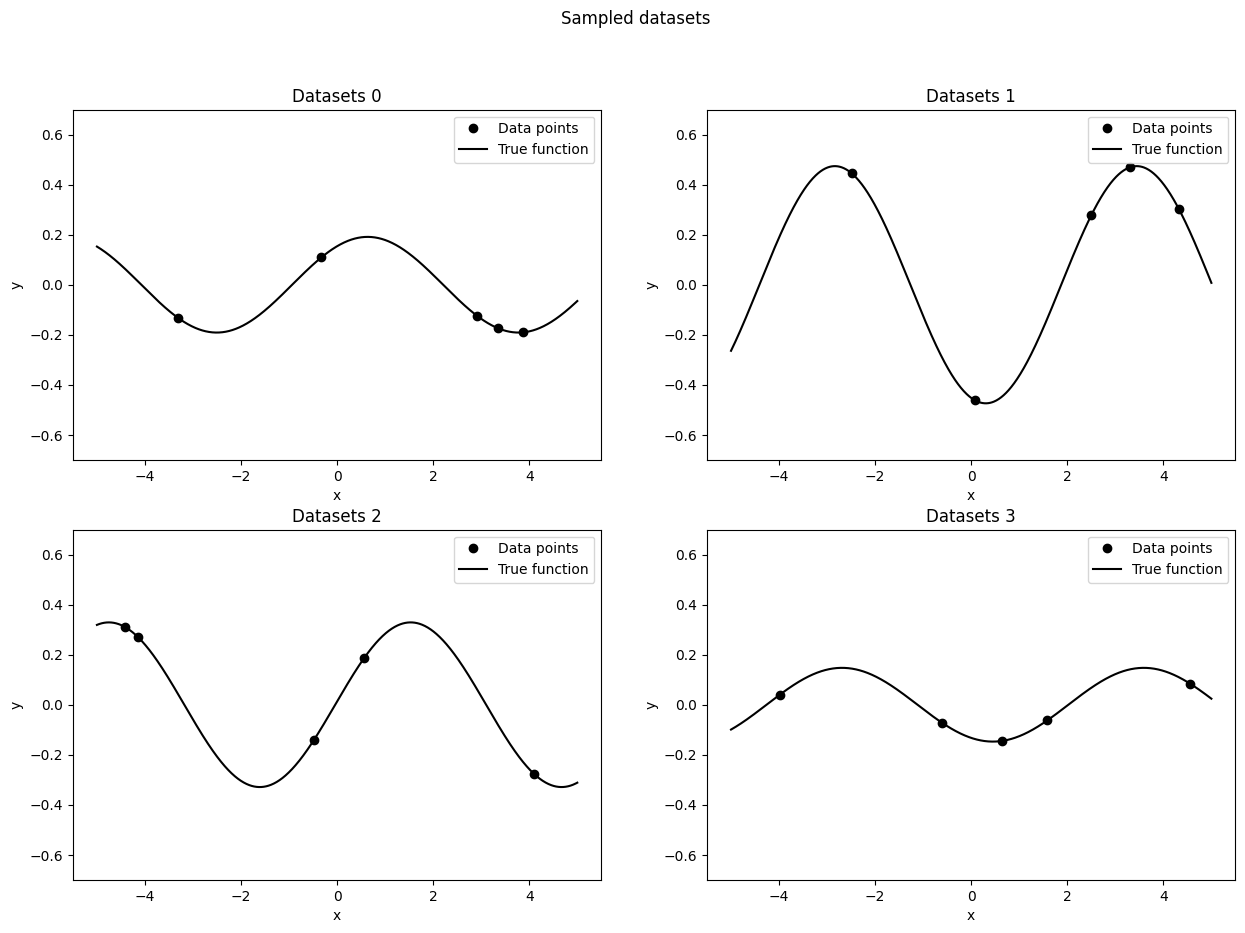

In [45]:
plot_x = 2
plot_y = 2
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
plt.suptitle("Sampled datasets")
for i in range(plot_x):
    for j in range(plot_y):
        idx = i * plot_y + j
        ax[i, j].plot(batch_x_val[idx, :, 0], batch_y_val[idx, :, 0], 'ko', label='Data points')
        ax[i, j].plot(x_dense, batch_y_val_dense[idx].T, 'k', label='True function')
        ax[i, j].set_title(f"Datasets {idx}")
        ax[i, j].set_xlabel("x")
        ax[i, j].set_ylabel("y")
        ax[i, j].set_ylim(-.7, .7)
        ax[i, j].legend(loc='upper right')


## Standard training from scratch

Let us train distinct models from scratch on each dataset, with standard initialization. Let us first define a reasonable architecture.

Let us first define a reasonable base architecture, which for sure has the capacity to model those simple 1D sinusoid functions

In [46]:
# A simple MLP (stock code from copilot)
class MLP(nn.Module):
    hidden_size: int
    output_size: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.hidden_size)(x)
        x = nn.tanh(x)
        x = nn.Dense(self.hidden_size)(x)
        x = nn.tanh(x)
        x = nn.Dense(self.output_size)(x)
        return x
    
# Initialize the MLP
mlp = MLP(hidden_size=40, output_size=1)

 First let now define a function that train single a model on single a dataset.

In [47]:
# Function that trains a single model

def loss_fn(p, x, y):
    y_hat = mlp.apply(p, x)
    loss = jnp.mean((y - y_hat) ** 2)
    return loss

def train(params, x, y):
    iters = 5000

    loss_cfg = partial(loss_fn, x=x, y=y)
    opt = optax.adamw(learning_rate=1e-2)
    state = train_state.TrainState.create(apply_fn=loss_cfg, params=params, tx=opt)

    @jax.jit
    def make_step(state):
        loss, grads = jax.value_and_grad(state.apply_fn)(state.params)
        state = state.apply_gradients(grads=grads)
        return loss, state

    losses = jnp.empty(iters)
    for idx in range(iters):
        loss, state = make_step(state)
        losses = losses.at[idx].set(loss)
        # pbar.set_postfix_str(loss.item())

    return state.params, jnp.array(losses)

In [48]:
key, subkey = jr.split(key)
params_init = mlp.init(subkey, jnp.ones((1,)))

In [49]:
# Training of a single model
# params_fitted_one, loss = train(params_init, batch_x_val[0, :, None], batch_y_val[0, :, None])
# y_hat = mlp.apply(params_fitted_one, x_dense[..., None])

# fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# ax[0].plot(loss)
# ax[0].set_title('Loss')
# ax[0].set_xlabel('Iteration')
# ax[0].set_ylabel('Loss')
# ax[1].plot(x_dense, batch_y_dense[0])
# ax[1].set_prop_cycle(None)  # Reset the color cycle to ensure the same colors are used
# ax[1].plot(batch_x_val[0], batch_y_val[0], '^')
# ax[1].set_prop_cycle(None)  # Reset the color cycle to ensure the same colors are used
# ax[1].plot(x_dense, y_hat, '--')
# ax[1].set_title('Fitted function')
# ax[1].set_xlabel('x')
# ax[1].set_ylabel('y');

Training of ``batch_size`` models in parallel, one per validation dataset.

In [50]:
params_standard, losses = jax.vmap(train, in_axes=(None, 0, 0))(params_init, batch_x_val[..., None], batch_y_val[..., None]) # params of standard training

In [51]:
batch_y_hat_standard = jax.vmap(mlp.apply, in_axes=(0, None))(params_standard, x_dense[..., None]) # predictions of standard training
batch_y_hat_standard.shape

(32, 1000, 1)

In [52]:
# Plot too information-dense
# plt.figure()
# plt.plot(batch_x_val[:plot_num, :, 0].T, batch_y_val[:plot_num, :, 0].T, '^')
# plt.gca().set_prop_cycle(None)  # Reset the color cycle to ensure the same colors are used
# plt.plot(x_dense, batch_y_dense[:plot_num].T)
# plt.gca().set_prop_cycle(None)  # Reset the color cycle to ensure the same colors are used
# plt.plot(x_dense, y_hat[:plot_num, :, 0].T, "--");

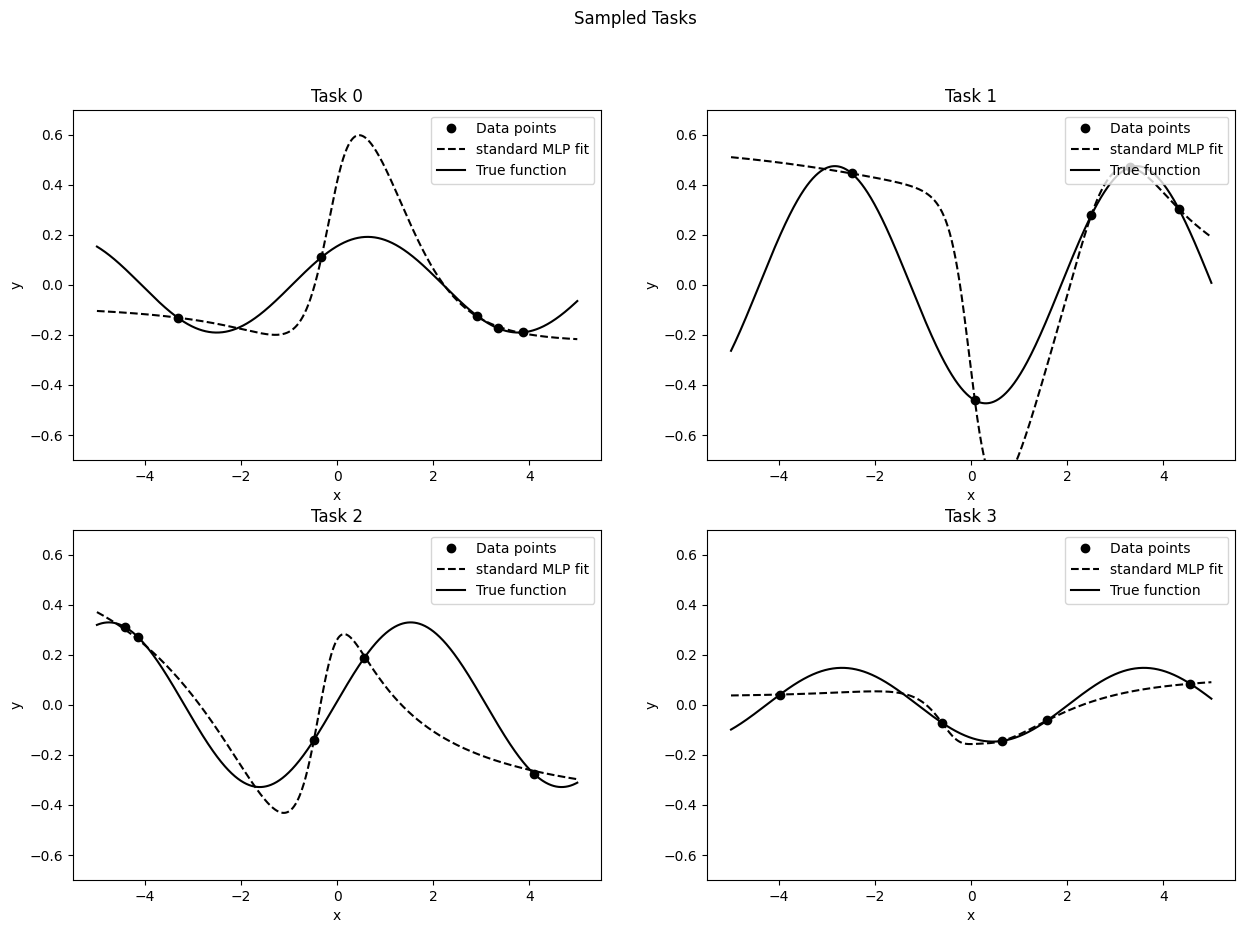

In [53]:
plot_x = 2
plot_y = 2
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
plt.suptitle("Sampled Tasks")
for i in range(plot_x):
    for j in range(plot_y):
        idx = i * plot_y + j
        ax[i, j].plot(batch_x_val[idx, :, 0], batch_y_val[idx, :, 0], 'ko', label='Data points')
        ax[i, j].plot(x_dense, batch_y_hat_standard[idx, :, 0].T, "k--", label='standard MLP fit')
        ax[i, j].plot(x_dense, batch_y_val_dense[idx].T, 'k', label='True function')
        ax[i, j].set_title(f"Task {idx}")
        ax[i, j].set_xlabel("x")
        ax[i, j].set_ylabel("y")
        ax[i, j].set_ylim(-.7, .7)
        ax[i, j].legend(loc='upper right')

In [54]:
errors = jnp.mean((batch_y_val_dense - batch_y_hat_standard[:, :, 0])**2, axis=1)
jnp.mean(errors), jnp.std(errors)

(Array(0.06514975, dtype=float32), Array(0.07113526, dtype=float32))

Due to the extremely low amount of data, we have severe overfitting issues

## MAML implementation

In [55]:
iters = 20_000 # outer loop iterations
lr = 1e-3 # outer loop learning rate
alpha = .1 # inner loop learning rate (just one step)

We will meta-learn the MAML initialization from batches of datasets sampled from the task distribution. Let us make one as an example.

In [56]:
key, subkey = jr.split(key)
batch_x, batch_y, amplitudes, phases = sample_datasets(subkey, batch_size=batch_size, K=K*2, return_params=True)

We split the points of each dataset in support and query sets

In [57]:
# support set, aka context, training set
batch_x1 = batch_x[:, :K//2]
batch_y1 = batch_y[:, :K//2]
# query set, test set
batch_x2 = batch_x[:, K//2:]
batch_y2 = batch_y[:, K//2:]

Let us initialize the MLP parameters that will be meta-optimized with MAML

In [58]:
key, subkey = jr.split(key)
params_maml = mlp.init(subkey, jnp.ones((1,)))

Let us test the regression loss on a single dataset

In [59]:

loss_fn(params_maml, batch_x1[0, :, None], batch_y1[0, :, None])

Array(0.31990665, dtype=float32)

Let us define and test the MAML loss for a single dataset

In [60]:
def inner_update(p, x1, y1, iters=1):
    grad_fn = jax.jit(jax.grad(loss_fn))
    for _ in range(iters):
        grads = grad_fn(p, x1, y1) #jax.grad(loss_fn)(p, x1, y1)
        inner_sgd_fn = lambda g, p: (p - alpha*g)
        p = jax.tree_util.tree_map(inner_sgd_fn, grads, p)
    return p
#    Simpler 1-step version
#    grads = jax.grad(loss_fn)(p, x1, y1)
#    inner_sgd_fn = lambda g, p: (p - alpha*g)
#    return jax.tree_util.tree_map(inner_sgd_fn, grads, p)

def maml_loss(p, x1, y1, x2, y2):
    p2 = inner_update(p, x1, y1)
    return loss_fn(p2, x2, y2)

maml_loss(params_init, batch_x1[0], batch_y1[0], batch_x2[0], batch_y2[0])

Array(4.5764594, dtype=float32)

Let us vectorize the MAML loss with ``vmap``

In [61]:
def batched_maml_loss(p, x1_b, y1_b, x2_b, y2_b):
    maml_loss_cfg = partial(maml_loss, p) # fix first argument
    maml_loss_batch = jax.vmap(maml_loss_cfg) # vmap over the rest
    batch_losses = maml_loss_batch(x1_b, y1_b, x2_b, y2_b)
    return jnp.mean(batch_losses)

batched_maml_loss(params_maml, batch_x1, batch_y1, batch_x2, batch_y2)

Array(3.03954, dtype=float32)

Let us set-up the MAML meta-optimization

In [62]:
meta_optimizer = optax.adam(learning_rate=lr)
meta_opt_state = meta_optimizer.init(params_maml)

@jax.jit
def make_step(p, s, x1, y1, x2, y2):
    l, g = jax.value_and_grad(batched_maml_loss)(p, x1, y1, x2, y2)
    u, s = meta_optimizer.update(g, s)
    p = optax.apply_updates(p, u)
    return p, s, l


losses = []
for i in tqdm(range(iters)):
    key, subkey = jr.split(key)
    
    batch_x, batch_y = sample_datasets(subkey, batch_size=batch_size, K=K)
    batch_x1 = batch_x[:, :K//2]
    batch_y1 = batch_y[:, :K//2]
    batch_x2 = batch_x[:, K//2:]
    batch_y2 = batch_y[:, K//2:]

    params_maml, meta_opt_state, loss = make_step(
        params_maml, meta_opt_state, batch_x1, batch_y1, batch_x2, batch_y2
    )
    losses.append(loss)

100%|██████████| 20000/20000 [00:14<00:00, 1340.71it/s]


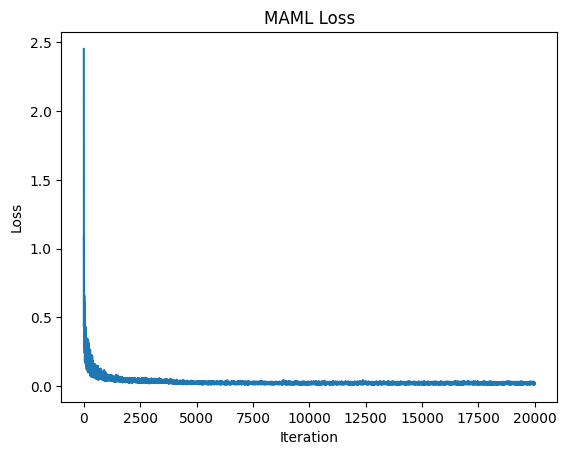

In [63]:
plt.figure()
plt.title('MAML Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.plot(losses);

## Compare MAML training vs. standard training from scratch

In [64]:
# Train with 1 GD step starting from the MAML params, exactly as in meta-optimization
# Running more steps (eg iters=10) does help in this case, feel free to try!
train_fn = partial(inner_update, iters=1)
params_maml_opt = jax.vmap(train_fn, in_axes=(None, 0, 0))(params_maml, batch_x_val, batch_y_val)
batch_y_hat_maml = jax.vmap(mlp.apply, in_axes=(0, None))(params_maml_opt, x_dense[..., None])

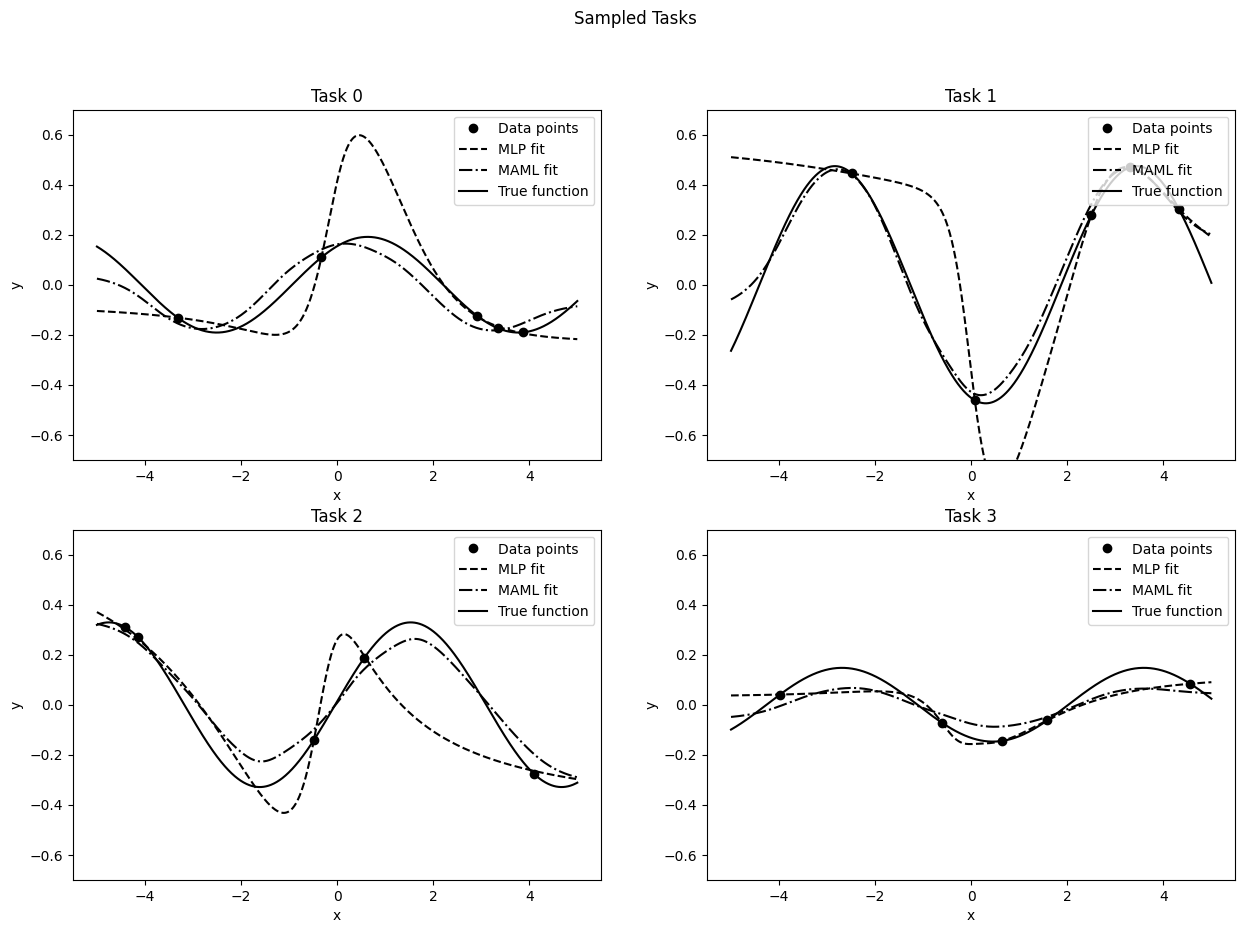

In [65]:
plot_x = 2
plot_y = 2
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
plt.suptitle("Sampled Tasks")
for i in range(plot_x):
    for j in range(plot_y):
        idx = i * plot_y + j
        ax[i, j].plot(batch_x_val[idx, :, 0], batch_y_val[idx, :, 0], 'ko', label='Data points')
        ax[i, j].plot(x_dense, batch_y_hat_standard[idx, :, 0].T, "k--", label='MLP fit')
        ax[i, j].plot(x_dense, batch_y_hat_maml[idx, :, 0].T, "k-.", label='MAML fit')
        ax[i, j].plot(x_dense, batch_y_val_dense[idx].T, 'k', label='True function')
        ax[i, j].set_title(f"Task {idx}")
        ax[i, j].set_xlabel("x")
        ax[i, j].set_ylabel("y")
        ax[i, j].set_ylim(-.7, .7)
        ax[i, j].legend(loc='upper right')

In [66]:
errors_standard = jnp.mean((batch_y_val_dense - batch_y_hat_standard[:, :, 0])**2, axis=1)
jnp.mean(errors_standard), jnp.std(errors_standard)

(Array(0.06514975, dtype=float32), Array(0.07113526, dtype=float32))

In [67]:
errors_maml = jnp.mean((batch_y_val_dense - batch_y_hat_maml[:, :, 0])**2, axis=1)
jnp.mean(errors_maml), jnp.std(errors_maml)

(Array(0.01086861, dtype=float32), Array(0.01344957, dtype=float32))

In [68]:
jnp.mean(errors_standard) / jnp.mean(errors_maml)

Array(5.994306, dtype=float32)

In [69]:
# batch_plot = 4
# plt.figure()
# plt.plot(batch_x_val[:batch_plot, :, 0].T, batch_y_val[:batch_plot, :, 0].T, 'o')
# plt.gca().set_prop_cycle(None)  # Reset the color cycle to ensure the same colors are used
# plt.plot(x_dense, batch_y_val_dense[:batch_plot].T)
# plt.gca().set_prop_cycle(None)  # Reset the color cycle to ensure the same colors are used
# plt.plot(x_dense, batch_y_hat_standard[:batch_plot, :, 0].T, "-.");
# plt.gca().set_prop_cycle(None)  # Reset the color cycle to ensure the same colors are used
# plt.plot(x_dense, batch_y_hat_maml[:batch_plot, :, 0].T, "--");